In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import mxnet as mx 
from Symbol.symbol import YOLO_loss
from data_ulti import get_iterator
import cv2

In [52]:
def decodeBox(yolobox, size, dscale):
    i, j, cx, cy, w, h, cls1, cls2, cls3, cls4 = yolobox
    cxt = j*dscale + cx*dscale
    cyt = i*dscale + cy*dscale
    wt = w*size
    ht = h*size
    clsa = np.argmax([cls1, cls2, cls3, cls4])
    if clsa==0:
        cls=1
    elif clsa==1:
        cls=2
    elif clsa==2:
        cls=3
    elif clsa==3:
        cls=20
    print(cls)
    return [cxt, cyt, wt, ht, cls]


def bboxdraw(img, label, dscale=32):
    #assert label.shape == (7,7,9)
    size = img.shape[1]
    ilist, jlist = np.where(label[:,:,0]>0.5)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)
    ax.imshow(np.uint8(img))
    for i,j in zip(ilist, jlist): 
        cx,cy,w,h,cls1, cls2, cls3, cls4 = label[i,j,1:]
        cxt, cyt, wt ,ht, cls = decodeBox([i, j, cx,cy,w,h,cls1, cls2, cls3, cls4], size, dscale)
        prob = label[i, j, 0]
        # Create a Rectangle patch
        rect = patches.Rectangle((cxt-wt/2,cyt-ht/2), wt,ht,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    
        name="unkown"
        if cls==1:
            name="car"
        elif cls==2:
            name="pedestrian"
        elif cls==3:
            name="cyclist"
        elif cls==20:
            name="traffic lights"
        
        plt.text(x=int(cxt-wt/2), y=int(cyt-ht/2), s=str(name)+str(prob) ,bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

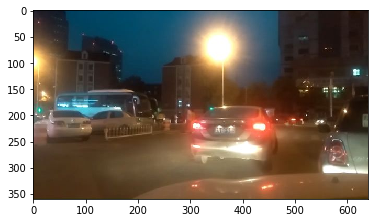

Orignal Img
Resize Img


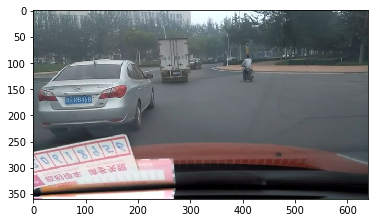

Orignal Img
Resize Img


In [53]:

cat = plt.imread("DATA/testing/testing/70725.jpg")
hi, wi = cat.shape[:2]
plt.imshow(cat)
plt.show()
print ("Orignal Img")
W = int(224 * (wi * 1.0 / hi))
H = 224
cat_resize = cv2.resize(cat, (W,H))
cat_resize = cat_resize.transpose((2,0,1)).reshape(1,3,H,W)

print ("Resize Img")

cat1 = plt.imread("DATA/testing/testing/71905.jpg")
hi, wi = cat1.shape[:2]
plt.imshow(cat1)
plt.show()
print ("Orignal Img")
W = int(224 * (wi * 1.0 / hi))
H = 224
cat1_resize = cv2.resize(cat1, (W,H))
cat1_resize = cat1_resize.transpose((2,0,1)).reshape(1,3,H,W)

print ("Resize Img")
img = np.vstack([cat_resize,cat1_resize])

In [54]:

cat_nd = mx.nd.array(ctx=mx.gpu(0), source_array=img)


print (cat_resize.shape)
print (cat_nd.shape)

cat_itr = mx.io.NDArrayIter(data=cat_nd, data_name='data',  batch_size=1)

(1, 3, 224, 398)
(2, 3, 224, 398)


In [55]:
# get sym 
sym, args_params, aux_params = mx.model.load_checkpoint('drive_full_detect', 418)
logit = sym.get_internals()['logit_output']
mod = mx.mod.Module(symbol=logit, context=mx.gpu(0))
mod.bind(cat_itr.provide_data)
mod.init_params(allow_missing=False, arg_params=args_params, aux_params=aux_params, 
                initializer=mx.init.Xavier(magnitude=2,rnd_type='gaussian',factor_type='in'))
out = mod.predict(eval_data=cat_itr, num_batch=10)

print(out.shape)

(2, 7, 13, 9)


/usr/local/lib/python3.5/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python3.5/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


1
1
1
1


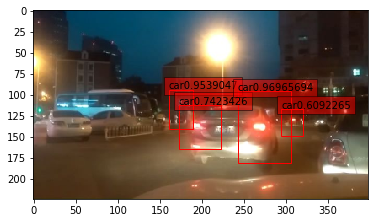

1
1
1
3


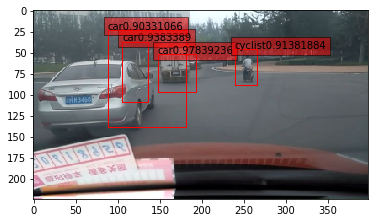

In [56]:
cat_itr.reset()
for i in range(2):
    batch = cat_itr.next()
    img = batch.data[0].asnumpy()[0].transpose((1,2,0))
    #label = batch.label[0].asnumpy().reshape((7,7,9))
    pred = (out.asnumpy()[i]+1)/2

    bboxdraw(img, pred)

